In [1]:
import numpy as np
from numba import (
    uint32, uint64, float32, 
    cuda
)

class CudaXorShiftStar(object):
    __NB_OF_THREADS_PER_BLOCK = 1024
    __NB_OF_BLOCKS = 65535
    
    __MAX32 = uint32(0xffffffff)
    
    def __init__(self, **kwargs):
        self.__values = np.empty((0,))
        self.__seed_dim = 0
          
        self.__init_kwargs(**kwargs)
        self.__d_seeds = self.__init_seeds(self.__seed_offset)
        
    def __init_kwargs(self, **kwargs):
        self.__seed_offset = kwargs.get("seed_offset", 0)
        self.__NB_OF_THREADS_PER_BLOCK = kwargs.get("nb_threads", self.__NB_OF_THREADS_PER_BLOCK)
        self.__NB_OF_BLOCKS = kwargs.get("nb_blocks", self.__NB_OF_BLOCKS)            
    
    def __init_seeds(self, offset):
        @cuda.jit(device=True)
        def wang_hash(seed):
            seed = (seed ^ 61) ^ (seed >> 16)
            seed *= 9
            seed = seed ^ (seed >> 4)
            seed *= 0x27d4eb2d
            seed = seed ^ (seed >> 15)
            return seed
        
        @cuda.jit
        def kernel_seeds(states, offset):
            pos = cuda.grid(1)
            if pos < states.size:
                states[pos] = wang_hash(pos + offset)
                
        nb_bks, nb_thds = self.__NB_OF_THREADS_PER_BLOCK, self.__NB_OF_THREADS_PER_BLOCK
        
        self.__seed_dim = nb_bks * nb_thds
        d_arr = cuda.device_array((self.__seed_dim, ), dtype=np.uint64)
        kernel_seeds[nb_bks, nb_thds](d_arr, offset)
        return d_arr
    
    def __compute_values(self, number):
        max32 = self.__MAX32
        
        @cuda.jit(device=True)
        def cuda_xorshift(states, id):
            x = states[id]
            x ^= x >> 12
            x ^= x << 25
            x ^= x >> 27
            states[id] = x
            return uint64(x) * uint64(2685821657736338717)
        
        @cuda.jit(device=True)
        def cuda_xorshift_float(states, id):
            return float32(float32(max32 & cuda_xorshift(states, id)) / float32(max32))
        
        @cuda.jit
        def kernel_randoms(seeds, arr):
            pos = cuda.grid(1)
            if pos < arr.size:
                arr[pos] = cuda_xorshift_float(seeds, pos)
            
        nb_bks, nb_thds = self.__NB_OF_THREADS_PER_BLOCK, self.__NB_OF_THREADS_PER_BLOCK
        d_arr = cuda.device_array((number, ))
        kernel_randoms[nb_bks, nb_thds](self.__d_seeds, d_arr)
        return d_arr.copy_to_host()
    
    def __call__(self, *shape):
        asked_count = np.prod(shape)
        avlbls_count = self.__values.size
        needed_count = asked_count - avlbls_count
        
        nb_loops = self.compute_divisor(needed_count, self.__seed_dim)
        nb_per_loop = self.__seed_dim
        
        for i in range(nb_loops):
            arr = self.__compute_values(nb_per_loop)
            self.__values = np.append(self.__values, arr)
        
        res = self.__values[0:asked_count]
        self.__values = self.__values[asked_count:]
        
        return res.reshape(shape)
    
    def precomputed_count_left(self):
        return self.__values.size
    
    def next(self):
        return self(1)[0]
    
    @property
    def NB_OF_THREADS_PER_BLOCK(self):
        return self.__NB_OF_THREADS_PER_BLOCK
    
    @property
    def NB_OF_BLOCKS(self):
        return self.__NB_OF_BLOCKS
    
    @staticmethod
    def compute_divisor(n, m):
        return (n + m - 1) // m

In [2]:
u_gen = CudaXorShiftStar()
print u_gen.NB_OF_BLOCKS
print u_gen.NB_OF_THREADS_PER_BLOCK

65535
1024


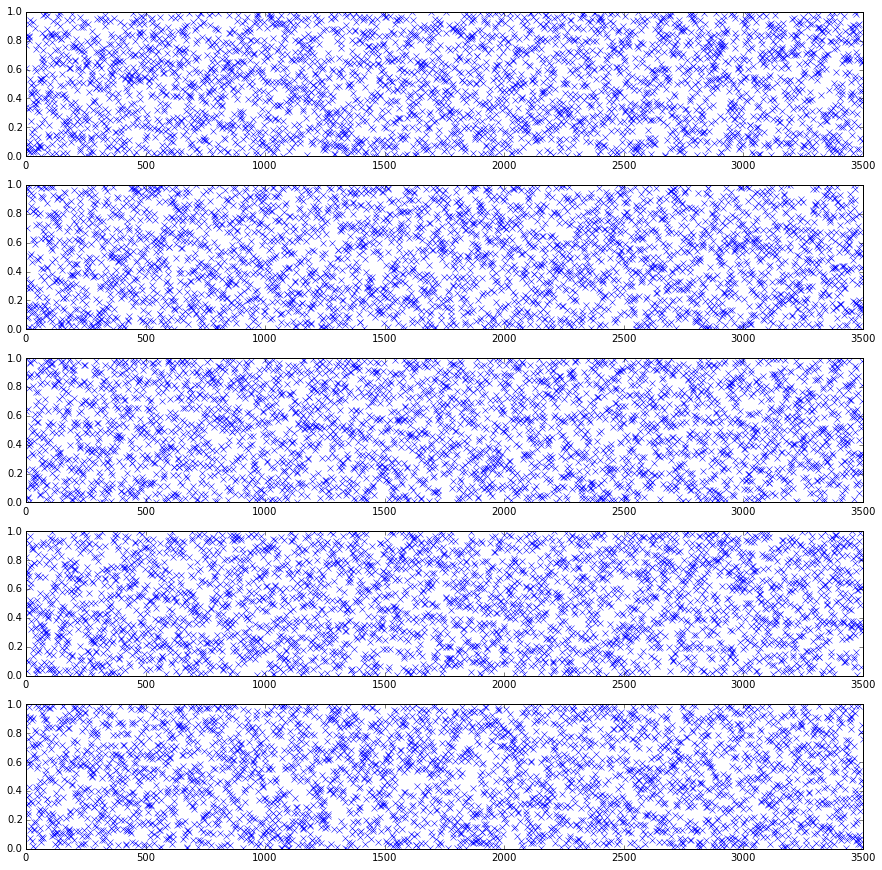

In [3]:
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
#sns.set_context('talk')

fig = plt.figure(figsize=(15, 15))
N = 5
for i in range(N):
    ax = fig.add_subplot(N, 1, i+1)
    ax.plot(u_gen(3500), 'x')

plt.show()

In [4]:
N = 100000

In [5]:
%timeit np.random.rand(N)

1000 loops, best of 3: 1.24 ms per loop


In [6]:
u_gen = CudaXorShiftStar()
u_gen(N)

array([ 0.33769342,  0.61276489,  0.77092212, ...,  0.96778619,
        0.0036044 ,  0.53247118])

In [7]:
%timeit u_gen(N)

100 loops, best of 3: 13.4 ms per loop


In [8]:
u_gen.precomputed_count_left()

743040

In [9]:
u_gen(N)

array([ 0.26476085,  0.34967175,  0.42347789, ...,  0.91241211,
        0.10647824,  0.41444901])

In [10]:
u_gen.precomputed_count_left()

643040

#### The question is: how can I improve these numbers??